In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers
from keras.utils import custom_object_scope
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM
import yfinance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def plot_history(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs = range(len(train_loss))

    # plot loss
    plt.clf()
    fig = plt.figure()
    plt.plot(train_loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend(loc='best')
    plt.title('Training and Testing Loss')
    plt.show()


In [28]:
starbucks = yfinance.Ticker('SBUX')
df = pd.DataFrame(data=starbucks.history(period='max'))
df = df.reset_index()
df = df.iloc[-7900:]
dates = df["Date"]
df = df[["Open","High","Low", "Close", "Volume"]]


In [29]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[["Open","High","Low", "Close", "Volume"]])
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

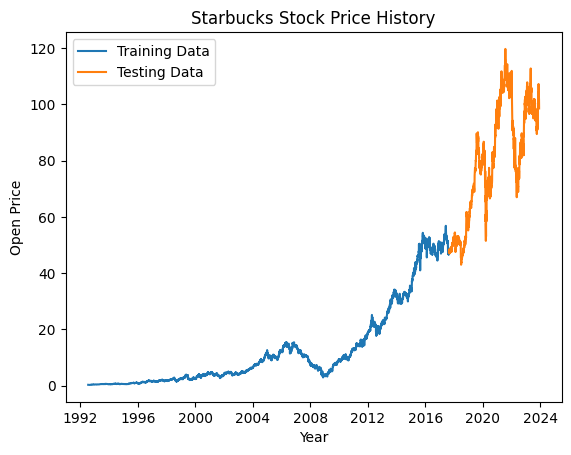

In [30]:
fig = plt.figure()
plt.plot(dates[:int(.8*len(df))], df["Open"][:int(.8*len(df))], label='Training Data')
plt.plot(dates[-int(.2*len(df)):], df["Open"][-int(.2*len(df)):], label='Testing Data')
plt.xlabel('Year')
plt.ylabel('Open Price')
plt.title('Starbucks Stock Price History')
plt.legend()
plt.show()

In [31]:
train_data = df_scaled.iloc[:int((.8*len(df_scaled)))]
test_data = df_scaled.iloc[int(-(.2*len(df_scaled))):]

train_data.shape[0]

6320

In [32]:
endtrain = int(.8*len(df_scaled))
timesteps = 4

X_train, X_test = [],[]
y_train, y_test = [],[]

for i in range(timesteps, train_data.shape[0]):
  X_train.append(train_data.iloc[i-timesteps:i].values)
  y_train.append(train_data.iloc[i])

for i in range(timesteps, test_data.shape[0]):
  X_test.append(test_data.iloc[i-timesteps:i].values)
  y_test.append(test_data.iloc[i])

X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [33]:
# Build tranformer encoder and model, the article "Transformers vs. LSTM for Stock Price Time Series Prediction" by Michael May helped a lot in making the model

def encoder(input, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6):

  #creates one transformer encoder block

  x = layers.LayerNormalization(epsilon=epsilon)(input)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + input

    # Feed Forward Part

  x = layers.LayerNormalization(epsilon=epsilon)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=input.shape[-1], kernel_size=1)(x)

  return x + res

In [34]:
def model(input_shape, head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, epsilon=1e-6):
  #Creates final model by stacking transformer encoders and finishing with convolutional and dense layers
  n_outputs = 5
  input = tf.keras.Input(shape=(input_shape))
  x = input
  for _ in range(num_trans_blocks):
    x = encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(input, outputs)



In [35]:
transformer = model((timesteps, 5), head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], dropout=0.10, mlp_dropout=0.10)
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 4, 5)]               0         []                            
                                                                                                  
 layer_normalization_16 (La  (None, 4, 5)                 10        ['input_3[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_8 (Mu  (None, 4, 5)                 11781     ['layer_normalization_16[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_16

64/64 [==============================] - 16s 108ms/step - loss: 0.0043 - mae: 0.0399 - mape: 7223.7178 - val_loss: 0.0090 - val_mae: 0.0758 - val_mape: 23.5657


<Figure size 640x480 with 0 Axes>

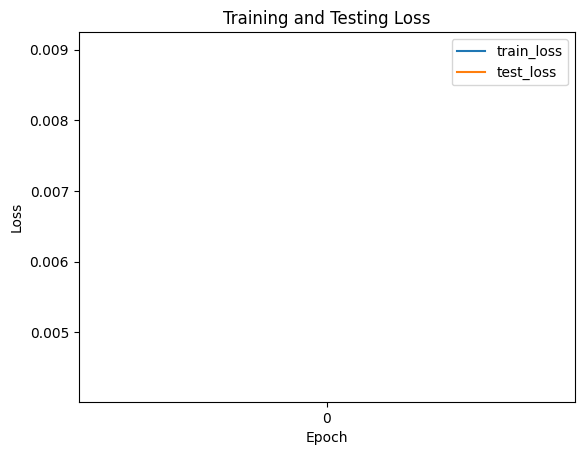

In [36]:
transformer.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])
hist = transformer.fit(X_train, y_train, epochs=1, batch_size=100, validation_data=(X_test, y_test))
plot_history(hist)

In [37]:
predict = transformer.predict(X_test)
predict = scaler.inverse_transform(predict)[:,3]
actual = scaler.inverse_transform(y_test)[:,3]

predict = pd.DataFrame(data=predict)
actual = pd.DataFrame(data=actual)
print(predict.shape)
print(actual.shape)

50/50 [==============================] - 1s 11ms/step
(1576, 1)
(1576, 1)


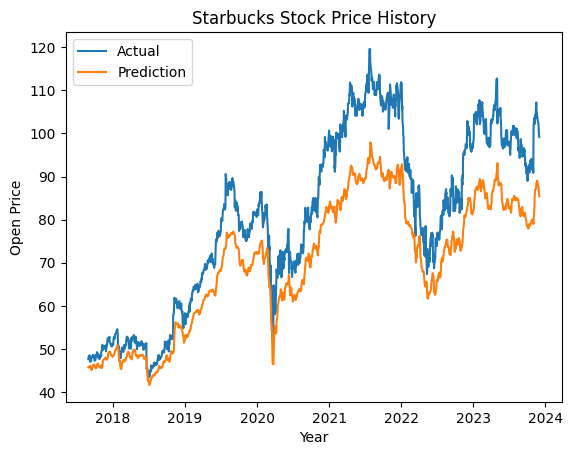

In [38]:
fig = plt.figure()
plt.plot(dates[timesteps+int(.8*len(df)):], actual, label='Actual')
plt.plot(dates[timesteps+int(.8*len(df)):], predict, label='Prediction')
plt.xlabel('Year')
plt.ylabel('Open Price')
plt.title('Starbucks Stock Price History')
plt.legend()
plt.show()